### Imports

In [207]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tqdm
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.metrics import confusion_matrix
import seaborn as sn

### Load data

In [2]:
communication = pd.read_csv("data/communication.csv", sep=";")
reportsto = pd.read_csv("data/reportsto.csv", sep=";")

In [3]:
communication

,Sender,Recipient,EventDate
0,17,37,2010-01-02 17:40:10
1,17,136,2010-01-02 17:40:10
2,17,62,2010-01-02 17:40:10
3,17,129,2010-01-02 17:40:10
4,17,32,2010-01-02 17:40:10
...,...,...,...
82922,136,143,2010-09-30 17:38:57
82923,136,143,2010-09-30 17:39:12
82924,81,39,2010-09-30 20:18:57
82925,155,136,2010-09-30 22:07:49


In [4]:
reportsto = reportsto[reportsto['ReportsToID'] != 'technical email account - not used by employees']
reportsto = reportsto[reportsto['ReportsToID'] != 'former employee account']

In [5]:
reportsto

,ID,ReportsToID
0,1,152
1,2,132
2,3,152
4,5,36
5,6,163
...,...,...
162,163,86
163,164,137
164,165,29
165,166,159


In [6]:
reportsto['ReportsToID'] = pd.to_numeric(reportsto['ReportsToID'])

In [7]:
high_level = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
middle_level = [76, 90, 136, 137, 143, 152, 47, 162]

### Create graph

In [8]:
communication_grupped = communication.groupby(['Sender', 'Recipient']).size().reset_index().rename(columns={0:'count'})

In [9]:
communication_grupped

,Sender,Recipient,count
0,1,2,1
1,1,3,1
2,3,8,1
3,3,13,3
4,3,19,6
...,...,...,...
5779,167,45,1
5780,167,89,1
5781,167,94,1
5782,167,102,1


In [10]:
def build_graph():
    G_communication = nx.Graph()
    G_communication.add_nodes_from(list(range(1, 167)))
    for index, row in communication_grupped.iterrows():
        G_communication.add_edge(row['Sender'], row['Recipient'], weight=row['count'])
    return G_communication
G_communication = build_graph()

In [11]:
print(len(G_communication.nodes))
print(len(G_communication.edges))

167
3251


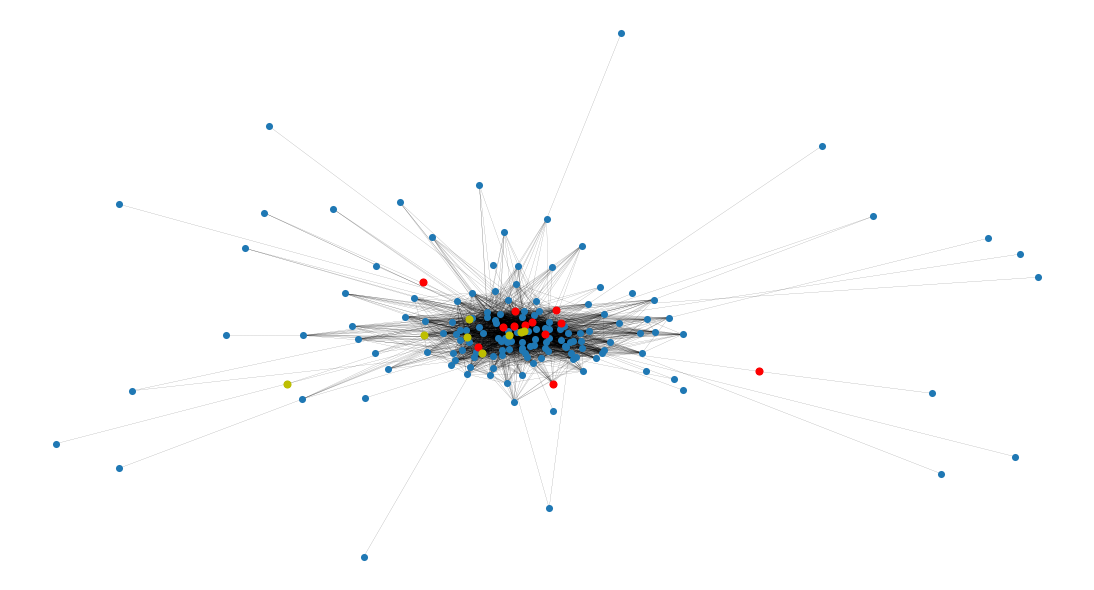

In [12]:
plt.figure(figsize=(15,8))
pos = nx.spring_layout(G_communication)
nx.draw(G_communication, pos, node_size=50,
    linewidths=0,
    width=0.1)
nx.draw_networkx_nodes(G_communication, pos,
                       nodelist=high_level,
                       node_color='r',
                       node_size=50)
nx.draw_networkx_nodes(G_communication, pos,
                       nodelist=middle_level,
                       node_color='y',
                       node_size=50)

### Node's labels & attributes

Setting real node's labels and additional attributes from data

In [13]:
# How many workers report to this worker
reportsto_grupped = reportsto.groupby(['ReportsToID']).size().reset_index().rename(columns={0:'count'})
reportsto_grupped

,ReportsToID,count
0,19,2
1,27,5
2,29,4
3,31,1
4,33,2
5,36,9
6,39,8
7,45,1
8,47,2
9,69,8


In [14]:
#How many emails worker recive
communication_recive = communication.groupby(['Recipient']).size().reset_index().rename(columns={0:'count'})

In [15]:
communication_recive[communication_recive['Recipient']==11]['count'].values[0]

2525

In [16]:
def set_nodes_static_attributes(G):
    reportsto_grupped = reportsto.groupby(['ReportsToID']).size().reset_index().rename(columns={0:'count'})
    communication_recived = communication.groupby(['Recipient']).size().reset_index().rename(columns={0:'count'})
    communication_send = communication.groupby(['Sender']).size().reset_index().rename(columns={0:'count'})
    attrs = {}
    for node in G.nodes():
        reporters_count = 0
        emails_recived = 0
        emails_send = 0
        if node in communication_recive['Recipient'].values.tolist():
            emails_recived = communication_recive[communication_recive['Recipient']==node]['count'].values[0]
        if node in reportsto_grupped['ReportsToID'].values.tolist():
            reporters_count = reportsto_grupped[reportsto_grupped['ReportsToID']==node]['count'].values[0]
        if node in communication_send['Sender'].values.tolist():
            emails_send = communication_send[communication_send['Sender']==node]['count'].values[0]
            
        attrs[node]={'node':node, 'reporters_count':reporters_count, 'recived_emails': emails_recived, 'send_emails':emails_send}
    nx.set_node_attributes(G, attrs)

In [17]:
def set_nodes_labels(G, nodes_to_uncover, high_level, middle_level):
    attrs = {}
    for node in nodes_to_uncover:
        if node in high_level:
            attrs[node]={'true_y': 2}
        elif node in middle_level:
            attrs[node]={'true_y': 1}
        else:
            attrs[node]={'true_y': 0}
    nx.set_node_attributes(G, attrs)     

In [18]:
def set_nodes_network_attributes(G):
    nx.set_node_attributes(G, nx.betweenness_centrality(G), "betweenness")
    nx.set_node_attributes(G, nx.closeness_centrality(G), "closeness")
    nx.set_node_attributes(G, nx.eigenvector_centrality(G), "eigenvector")
    nx.set_node_attributes(G, nx.degree_centrality(G), "degree")
    nx.set_node_attributes(G, nx.pagerank(G), "pagerank")

In [19]:
def set_node_dynamic_attribute(G,node,n):
    if 'true_y' in G.nodes[n]:
        label = G.nodes[n]['true_y']
        new_value = G.nodes[node][label] + 1
        nx.set_node_attributes(G, {node: {label: new_value}})
    elif 'pred_y' in G.nodes[n]:
        label = G.nodes[n]['pred_y']
        new_value = G.nodes[node][label] + 1
        nx.set_node_attributes(G, {node: {label: new_value}})

In [20]:
def set_nodes_dynamic_attributes(G):
    for node in G.nodes:
        nx.set_node_attributes(G, {node: {0: 0, 1: 0, 2: 0}})
    for node in G.nodes:
        for n in G.neighbors(node):
            set_node_dynamic_attribute(G,node,n)

In [21]:
def get_nodes_to_uncover(G, uncover_by,nodes_uncover_num):
    return [k for k in sorted(G.nodes, key=lambda item: G.nodes[item][uncover_by], reverse=True)][:nodes_uncover_num]

In [22]:
def delete_labels(G, nodes_to_uncover):
    for node in G.nodes():
        if node not in nodes_to_uncover:
            del G.nodes[node]['true_y']

In [23]:
def create_dataset(G, nodes_to_uncover):
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    #set_nodes_labels(G, x_test.index.values.tolist(), high_level, middle_level)
    for node in G.nodes():
        if node in nodes_to_uncover:
            x_train = x_train.append(G.nodes[node], ignore_index=True)
        else:
            x_test = x_test.append(G.nodes[node], ignore_index=True)
    x_train.set_index('node', drop=True, inplace=True)
    x_test.set_index('node', drop=True, inplace=True)
    
    
        
    y_train = x_train['true_y']
    #y_test = x_test['true_y']
    x_train = x_train.drop(columns='true_y')
    #x_test = x_test.drop(columns='true_y')
    #delete_labels(G, nodes_to_uncover)
    return x_train, y_train, x_test#, y_test

In [196]:
def create_dataset_2(G, nodes_to_uncover):
    x_train = pd.DataFrame()
    x_test = pd.DataFrame()
    for node in G.nodes():
        if node in nodes_to_uncover:
            x_train = x_train.append(G.nodes[node], ignore_index=True)
        else:
            x_test = x_test.append(G.nodes[node], ignore_index=True)
    x_train.set_index('node', drop=True, inplace=True)
    x_test.set_index('node', drop=True, inplace=True)
    
    
        
    y_train = x_train['true_y']
    y_test = x_test['true_y']
    x_train = x_train.drop(columns='true_y')
    x_test = x_test.drop(columns='true_y')
    return x_train, y_train, x_test, y_test

In [50]:
def get_y_true_pred(G):
    y_true = []
    y_pred = []
    for node in G.nodes:
        if 'pred_y' in G.nodes[node]:
            y_true.append(G.nodes[node]['true_y'])
            y_pred.append(int(G.nodes[node]['pred_y']))
    return y_true, y_pred

### Test helper functions

In [25]:
set_nodes_static_attributes(G_communication)
set_nodes_network_attributes(G_communication)
nodes_to_uncover = get_nodes_to_uncover(G_communication, 'betweenness', 10)
set_nodes_labels(G_communication, nodes_to_uncover, high_level, middle_level)
set_nodes_dynamic_attributes(G_communication)

In [26]:
nodes_to_uncover = get_nodes_to_uncover(G_communication, 'betweenness', 10)

In [27]:
x_train, y_train, x_test = create_dataset(G_communication, nodes_to_uncover)

In [28]:
x_train

,0,1,2,betweenness,closeness,degree,eigenvector,pagerank,recived_emails,reporters_count,send_emails
node,,,,,,,,,,,
8.0,7.0,0.0,2.0,0.033616,0.608059,0.403614,0.105242,0.013120,1069.0,0.0,1781.0
17.0,7.0,0.0,2.0,0.040290,0.813725,0.783133,0.169528,0.016595,1290.0,0.0,2086.0
36.0,8.0,0.0,1.0,0.038692,0.603636,0.397590,0.107510,0.015207,1261.0,9.0,1627.0
45.0,7.0,0.0,2.0,0.064695,0.842640,0.819277,0.170224,0.010484,748.0,1.0,709.0
73.0,7.0,0.0,2.0,0.036429,0.805825,0.771084,0.168768,0.007875,688.0,0.0,647.0
89.0,7.0,0.0,2.0,0.064963,0.842640,0.819277,0.169852,0.008231,402.0,0.0,355.0
121.0,8.0,0.0,1.0,0.026423,0.594982,0.361446,0.098849,0.008991,778.0,3.0,570.0
130.0,7.0,0.0,2.0,0.082420,0.855670,0.837349,0.171070,0.018547,560.0,0.0,1143.0
132.0,7.0,0.0,2.0,0.052367,0.813725,0.783133,0.168962,0.012654,1071.0,1.0,1062.0


In [29]:
nodes_to_uncover

[130, 89, 45, 132, 17, 36, 73, 164, 8, 121]

In [30]:
G_communication.nodes[36]

{'node': 36,
 'reporters_count': 9,
 'recived_emails': 1261,
 'send_emails': 1627,
 'betweenness': 0.038691568581211824,
 'closeness': 0.6036363636363636,
 'eigenvector': 0.10751033298775818,
 'degree': 0.39759036144578314,
 'pagerank': 0.015206647245163114,
 'true_y': 2,
 0: 8,
 1: 0,
 2: 1}

In [31]:
G_communication.nodes[1]

{'node': 1,
 'reporters_count': 0,
 'recived_emails': 0,
 'send_emails': 2,
 'betweenness': 3.6509675063891934e-06,
 'closeness': 0.3688888888888889,
 'eigenvector': 0.0021389109597515677,
 'degree': 0.012048192771084338,
 'pagerank': 0.000953609064687878,
 0: 0,
 1: 0,
 2: 0}

### ICA

In [162]:
G = build_graph()
set_nodes_static_attributes(G)
set_nodes_network_attributes(G)

In [169]:
def ica_algorithm(G, uncover_level, uncover_by, clf, iters):
    nodes_num = G.number_of_nodes()
    nodes_uncover_num = int(uncover_level * nodes_num)
    nodes_to_uncover = get_nodes_to_uncover(G, uncover_by, nodes_uncover_num)
    set_nodes_labels(G, nodes_to_uncover, high_level, middle_level)
    set_nodes_dynamic_attributes(G)
    x_train, y_train, x_test = create_dataset(G, nodes_to_uncover)
    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    for node, y in zip(x_test.index, y_pred):
        nx.set_node_attributes(G, {node: {'pred_y': int(y)}})
    not_stabilized = True
    num_of_iter = 0
    while not_stabilized and num_of_iter<iters:
        changes = 0
        for node in sorted(x_test.index, key=lambda item: x_test.loc[node, uncover_by], reverse=True):
            for n in G.neighbors(node):
                set_node_dynamic_attribute(G,node,n)
            for i in range(3):
                x_test.loc[node, i] = G.nodes[node][i]
            y = int(clf.predict([x_test.loc[node]])[0])
            if y != G.nodes[node]['pred_y']:
                changes +=1
            nx.set_node_attributes(G, {node: {'pred_y': y}})
        num_of_iter +=1
        if changes == 0:
            #print(f'stabilized: {num_of_iter}')
            not_stabilized = False
    set_nodes_labels(G, x_test.index.values.tolist(), high_level, middle_level)
    y_true, y_pred = get_y_true_pred(G)
    return y_true, y_pred

In [164]:
y_true, y_pred = ica_algorithm(G, 0.2, 'degree', RandomForestClassifier(random_state=137), 100)

stabilized: 6


In [165]:
print(len(y_true))
print(len(y_pred))

134
134


In [166]:
print(accuracy_score(y_true, y_pred)) 
print(f1_score(y_true, y_pred, average='macro'))
print(precision_score(y_true, y_pred, average='macro'))
print(recall_score(y_true, y_pred, average='macro'))

0.9104477611940298
0.5717729714836755
0.5789313904068002
0.569672131147541


### Experiments

In [167]:
uncover_level = [0.1, 0.2,0.3, 0.5]
uncover_by = ['betweenness', 'closeness', 'degree', 'pagerank']
clfs = [RandomForestClassifier(random_state=137), AdaBoostClassifier(random_state=137)]
iters = [20]

def run_experiments():
    results = pd.DataFrame()
    for level in uncover_level:
        print(level)
        for by in uncover_by:
            for clf in clfs:
                for it in iters:
                    G = build_graph()
                    set_nodes_static_attributes(G)
                    set_nodes_network_attributes(G)
                    y_true, y_pred = ica_algorithm(G,level, by, clf, it)
                    acc = accuracy_score(y_true, y_pred)
                    f1 = f1_score(y_true, y_pred, average='macro')
                    precision = precision_score(y_true, y_pred, average='macro')
                    recall = recall_score(y_true, y_pred, average='macro')
                    results = results.append({'uncover_level': level, 
                                              'uncover_by': by, 
                                              'clf': clf.__class__.__name__, 
                                              'iter_num': it, 
                                              'acc': acc, 
                                              'f1': f1, 'precision':precision, 
                                              'recall': recall}, ignore_index=True)
    return results
results = run_experiments()                    

0.1
stabilized: 1
stabilized: 2
stabilized: 2
stabilized: 5
stabilized: 2
stabilized: 5
stabilized: 7
stabilized: 6
0.2
stabilized: 2
stabilized: 1
stabilized: 2
stabilized: 2
stabilized: 6
stabilized: 2
stabilized: 1
stabilized: 3
0.3
stabilized: 2
stabilized: 3
stabilized: 2
stabilized: 4
stabilized: 1
stabilized: 4
stabilized: 2
stabilized: 2
0.5
stabilized: 5
stabilized: 5
stabilized: 1
stabilized: 1
stabilized: 1
stabilized: 1
stabilized: 1
stabilized: 2


In [176]:
results.sort_values(by=['f1'], ascending=False)

,acc,clf,f1,iter_num,precision,recall,uncover_by,uncover_level
12,0.910448,RandomForestClassifier,0.571773,20.0,0.578931,0.569672,degree,0.2
11,0.880597,AdaBoostClassifier,0.531751,20.0,0.497076,0.651471,closeness,0.2
13,0.873134,AdaBoostClassifier,0.524718,20.0,0.494152,0.639344,degree,0.2
25,0.809524,AdaBoostClassifier,0.505202,20.0,0.517247,0.608333,betweenness,0.5
10,0.880597,RandomForestClassifier,0.459241,20.0,0.425622,0.589237,closeness,0.2
17,0.905983,AdaBoostClassifier,0.452781,20.0,0.457996,0.462876,betweenness,0.3
31,0.916667,AdaBoostClassifier,0.415913,20.0,0.400000,0.435897,pagerank,0.5
9,0.895522,AdaBoostClassifier,0.398148,20.0,0.467172,0.386111,betweenness,0.2
15,0.671642,AdaBoostClassifier,0.395440,20.0,0.678158,0.530681,pagerank,0.2
18,0.888889,RandomForestClassifier,0.374152,20.0,0.359740,0.398318,closeness,0.3


In [171]:
results.to_csv('results.csv')

In [181]:
f1_deegree = []
f1_betweenness = []
f1_closeness = []
f1_pagerank = []
for i in [0.1, 0.2, 0.3, 0.4, 0.5]:
    G = build_graph()
    set_nodes_static_attributes(G)
    set_nodes_network_attributes(G)
    y_true, y_pred = ica_algorithm(G, i, 'degree', RandomForestClassifier(random_state=137), 20)
    f1_deegree.append(f1_score(y_true, y_pred, average='macro'))
    
    G = build_graph()
    set_nodes_static_attributes(G)
    set_nodes_network_attributes(G)
    y_true, y_pred = ica_algorithm(G, i, 'betweenness', RandomForestClassifier(random_state=137), 20)
    f1_betweenness.append(f1_score(y_true, y_pred, average='macro'))
    
    G = build_graph()
    set_nodes_static_attributes(G)
    set_nodes_network_attributes(G)
    y_true, y_pred = ica_algorithm(G, i, 'closeness', RandomForestClassifier(random_state=137), 20)
    f1_closeness.append(f1_score(y_true, y_pred, average='macro'))
    
    G = build_graph()
    set_nodes_static_attributes(G)
    set_nodes_network_attributes(G)
    y_true, y_pred = ica_algorithm(G, i, 'pagerank', RandomForestClassifier(random_state=137), 20)
    f1_pagerank.append(f1_score(y_true, y_pred, average='macro'))
    

Text(0, 0.5, 'f1 macro')

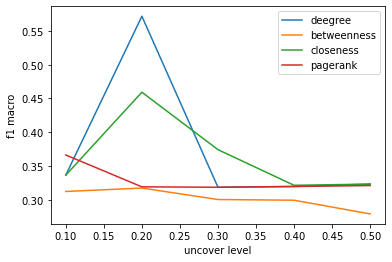

In [182]:
x = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.plot(x,f1_deegree, label='deegree')
plt.plot(x,f1_betweenness, label = 'betweenness')
plt.plot(x,f1_closeness, label = 'closeness')
plt.plot(x,f1_pagerank, label = 'pagerank')
plt.legend()
plt.xlabel('uncover level')
plt.ylabel('f1 macro')

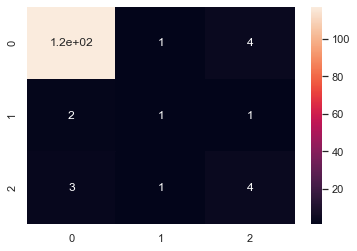

In [210]:
G = build_graph()
set_nodes_static_attributes(G)
set_nodes_network_attributes(G)
y_true, y_pred = ica_algorithm(G, 0.2, 'degree', RandomForestClassifier(random_state=137), 20)
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, range(3), range(3))
sn.set(font_scale=1) 
sn.heatmap(df_cm, annot=True) 

plt.show()

### Random classifier

In [197]:
def random_algorithm(G, uncover_level, clf):
    nodes_num = G.number_of_nodes()
    nodes_uncover_num = int(uncover_level * nodes_num)
    nodes_to_uncover = random.sample(G.nodes, nodes_uncover_num)
    set_nodes_labels(G, G.nodes(), high_level, middle_level)
    x_train, y_train, x_test, y_test = create_dataset_2(G, nodes_to_uncover)
    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_true = y_test
    return y_true, y_pred

In [213]:
uncover_level = [0.1, 0.2,0.3, 0.5]
clfs = [RandomForestClassifier(random_state=137), AdaBoostClassifier(random_state=137)]

def run_experiments_random():
    results = pd.DataFrame()
    for i in range(10):
        for level in uncover_level:
            for clf in clfs:
                G = build_graph()
                set_nodes_static_attributes(G)
                set_nodes_network_attributes(G)
                y_true, y_pred = random_algorithm(G,level,clf)
                acc = accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred, average='macro')
                precision = precision_score(y_true, y_pred, average='macro')
                recall = recall_score(y_true, y_pred, average='macro')
                results = results.append({'uncover_level': level, 
                                          'clf': clf.__class__.__name__, 
                                          'acc': acc, 
                                          'f1': f1, 'precision':precision, 
                                          'recall': recall}, ignore_index=True)
    return results
results_random = run_experiments_random()                    

In [217]:
results_random = results_random.groupby(['clf', 'uncover_level'])['f1','acc', 'recall', 'precision'].mean()

In [218]:
results_random

f1       acc    recall  precision
clf                    uncover_level                                         
AdaBoostClassifier     0.1            0.419082  0.853642  0.438742   0.434469
                       0.2            0.414391  0.770149  0.459774   0.430735
                       0.3            0.455951  0.822222  0.471375   0.492004
                       0.5            0.404597  0.734524  0.448690   0.431269
RandomForestClassifier 0.1            0.347947  0.860927  0.359180   0.366375
                       0.2            0.363213  0.850000  0.379654   0.399446
                       0.3            0.372389  0.878632  0.372648   0.461847
                       0.5            0.383856  0.866667  0.386863   0.419197

In [219]:
results_random.to_csv("results_random.csv")

### Podsumowanie i Wnioski

Miary najlepiej sprawdzające się w początkowej selekcji węzłów:
- deegree
- closeness (drugie miejsce)  

Najlepsza znaleziona konfiguracja parametrów dla algorytmu ICA:
- klasyfikator: RandomForest + poziom odkrycia wierzchołków: 0.2 + utility score: degree  

Najlepsza znaleziona konfiguracja parametrów dla algorytmu lsowego:
- klasyfikator: AdaBoost + poziom odkrycia wierzchołków: 0.3  

Najlepszy osiągnięty F1 dla algorytmu ICA:
- F1_macro = 0.571773  

Najlepszy osiągnięty F1 dla algorytmu losowego:
- F1_macro = 0.455951  

Wartość optymalna dla poziomu odkrycia etykiet wierzchołków wynosi ok. 0.2 - wyraźny pik na wykresie dla prawie wszyskich miar.

Wartości metryki F1 wynikają z dużego niezbalansowania zbioru

Wyniki dla algorytmu ICA są bardziej stabilne niż dla algorytmu losowego, którego użycie jest dużą niewiadomą, przy każdym uruchomieniu możemy spodziewać się zupełnie innych wyników w zależności od tego jakie wierzchołki początkowe wylosujemy.
Najbardziej uczciwym rozwiązaniem jest uśrednienie otrzymanych wyników z kilku iteracji - powyżej widać wyniki uśrednionych 10 iteracji. Widać, że średnio algorytm losowy sprawdza się gorzej niż ICA, a metryka F1 nie przekracza 45%